## Домашнее задание

Обучить полиномиальную регрессию, построить зависимость предсказанного от реального значения и рассчитать ошибку (всё для обучающей и тестовой выборок) для датасета сталей и предсказать предел текучести (0.2% Proof Stress (MPa)) на основании состава и температуры. Для большого числа признаков использовать регуляризацию. Постараться достичь минимально возможной ошибки на тестовой выборке. 

По желанию можно использовать кросс-валидацию для расчет метрики ошибки и поиск по сетке для подбора параметров регуляризации. Также можно самим реализовать алгоритм градиентного спуска и с его помощью рассчитать ошибку.

In [39]:
import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import SGDRegressor, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV


sns.set_style('darkgrid')
sns.set_palette('Set2')

In [6]:
df = pd.read_csv('./Databases/Steels_kaggle.csv')

In [7]:
target_class = ' 0.2% Proof Stress (MPa)'
y = df[target_class]
X = df.drop(np.hstack([df.columns[0], df.columns[16:]]), axis=1)


In [120]:

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

pipe = make_pipeline(
    PolynomialFeatures(degree=5, include_bias=False), 
    StandardScaler(), 
    Lasso(alpha=1, fit_intercept=True, max_iter=5000))
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.9182605975102863

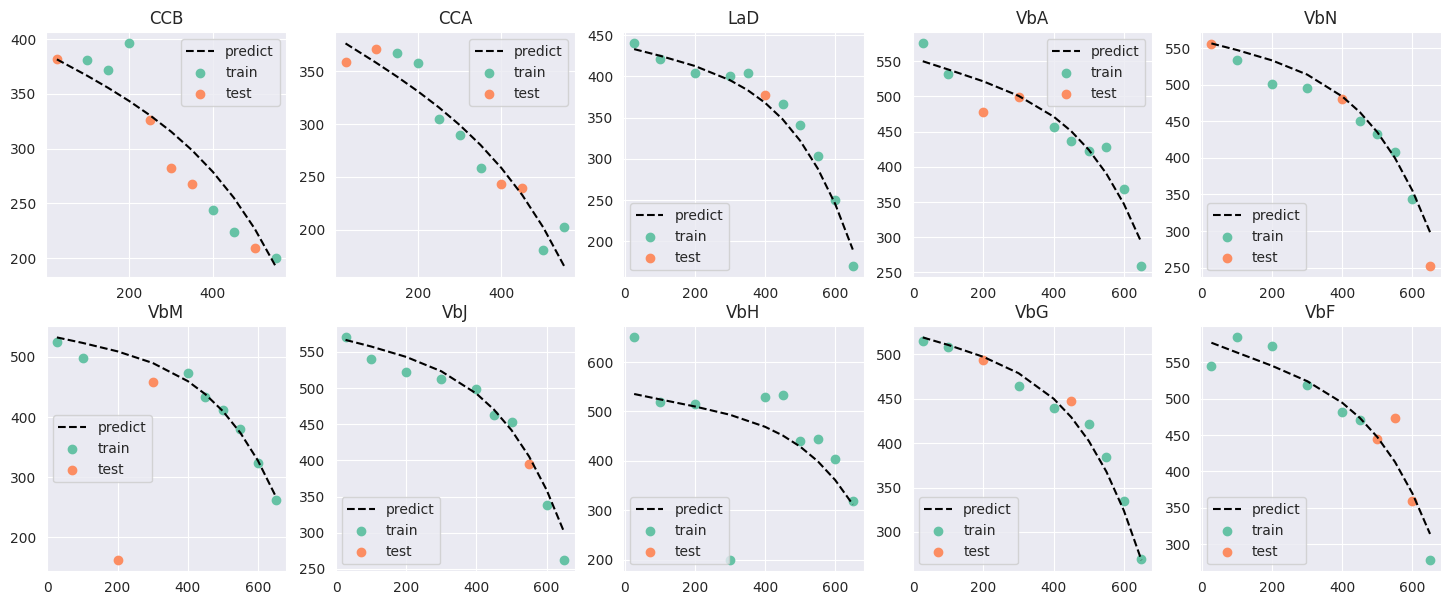

In [62]:
alloys = df['Alloy code'].value_counts().index[:10]

df_train = df.iloc[X_train.index]
df_test = df.iloc[X_test.index]

fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(18, 7))

for alloy_label, i in zip(alloys, range(10)):
    alloy = df[df['Alloy code'] == alloy_label]
    alloy_test = df_test[df_test['Alloy code'] == alloy_label]
    alloy_train = df_train[df_train['Alloy code'] == alloy_label]
    ax = axs[i // 5][i % 5]
    # ax.scatter(alloy[' Temperature (°C)'], alloy[' 0.2% Proof Stress (MPa)'])
    ax.plot(alloy[' Temperature (°C)'], pipe.predict(X[df['Alloy code'] == alloy_label]), c='k', linestyle='--', label='predict')
    ax.scatter(alloy_train[' Temperature (°C)'], alloy_train[' 0.2% Proof Stress (MPa)'], label='train')
    ax.scatter(alloy_test[' Temperature (°C)'], alloy_test[' 0.2% Proof Stress (MPa)'], label='test')
    ax.set_title(alloy_label)
    ax.legend()

Попробуем подобрать хорошие гиперпараметры для SGDRegressor'а

In [67]:
pipe2 = Pipeline([
    ('poly', PolynomialFeatures(include_bias=False)), 
    ('scaler', StandardScaler()), 
    ('SGD', SGDRegressor(penalty='elasticnet', alpha=1, fit_intercept=True))])

In [ ]:

param_grid = {
    
    'poly__degree': [2, 3, 4],
    'SGD__penalty': ['l1'],
    # 'SGD__eta0': [1],
    'SGD__alpha': [0.01, 0.1, 0.5, 1],
    'SGD__max_iter': [1000, 5000, 10000],
    'SGD__tol': [1e-5, 1e-6]
     
}

grid_search = GridSearchCV(pipe2, param_grid, cv=5, scoring='r2', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train);

In [53]:
pipe2.fit(X_train, y_train)
pipe2.score(X_test, y_test)

0.8276394057257319

In [115]:
grid_search.best_estimator_.score(X_test, y_test)

0.9019727849273093

In [116]:
grid_search.best_estimator_[0].degree

2

In [117]:
grid_search.best_estimator_

Pipeline(steps=[('poly', PolynomialFeatures(include_bias=False)),
                ('scaler', StandardScaler()),
                ('SGD',
                 SGDRegressor(alpha=0.01, max_iter=10000, penalty='l1',
                              tol=1e-05))])

Несмотря на мои попытки, не получилось сделать точность выше, чем у обычной лассо регрессии

Попробуем подобрать хороший `alpha` для лассо регрессии с помощью `GridSearchCV`

In [133]:
pipe3 = Pipeline([
    ('poly', PolynomialFeatures(degree=4, include_bias=False)), 
    ('scaler', StandardScaler()), 
    ('lasso', Lasso(alpha=1, fit_intercept=True, max_iter=10000))])


param_grid = {
    
    'poly__degree': [3, 4, 5, 6],
    'lasso__alpha': [0.01, 0.1, 0.5, 1, 2],
    'lasso__max_iter': [10000],
    # 'SGD__tol': [1e-5, 1e-6]
     
}

grid_search = GridSearchCV(pipe3, param_grid, cv=3, scoring='r2', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train);

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/home/masvel/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.382e+04, tolerance: 8.572e+02
  model = cd_fast.enet_coordinate_descent(


[CV] END lasso__alpha=0.01, lasso__max_iter=10000, poly__degree=3; total time=   5.4s


/home/masvel/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.948e+04, tolerance: 8.682e+02
  model = cd_fast.enet_coordinate_descent(


[CV] END lasso__alpha=0.01, lasso__max_iter=10000, poly__degree=3; total time=   5.8s


/home/masvel/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.740e+04, tolerance: 8.609e+02
  model = cd_fast.enet_coordinate_descent(


[CV] END lasso__alpha=0.01, lasso__max_iter=10000, poly__degree=3; total time=   6.5s


/home/masvel/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.637e+03, tolerance: 8.609e+02
  model = cd_fast.enet_coordinate_descent(
/home/masvel/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.424e+04, tolerance: 8.682e+02
  model = cd_fast.enet_coordinate_descent(


[CV] END lasso__alpha=0.01, lasso__max_iter=10000, poly__degree=4; total time=  50.3s
[CV] END lasso__alpha=0.01, lasso__max_iter=10000, poly__degree=4; total time=  50.5s
[CV] END lasso__alpha=0.1, lasso__max_iter=10000, poly__degree=3; total time=   3.4s


/home/masvel/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.283e+04, tolerance: 8.572e+02
  model = cd_fast.enet_coordinate_descent(


[CV] END lasso__alpha=0.01, lasso__max_iter=10000, poly__degree=4; total time=  54.5s
[CV] END lasso__alpha=0.1, lasso__max_iter=10000, poly__degree=3; total time=   3.1s
[CV] END lasso__alpha=0.1, lasso__max_iter=10000, poly__degree=3; total time=   3.8s


/home/masvel/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.824e+03, tolerance: 8.572e+02
  model = cd_fast.enet_coordinate_descent(


[CV] END lasso__alpha=0.1, lasso__max_iter=10000, poly__degree=4; total time=  33.6s


/home/masvel/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.044e+03, tolerance: 8.682e+02
  model = cd_fast.enet_coordinate_descent(


[CV] END lasso__alpha=0.1, lasso__max_iter=10000, poly__degree=4; total time=  42.0s


/home/masvel/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.272e+03, tolerance: 8.609e+02
  model = cd_fast.enet_coordinate_descent(


[CV] END lasso__alpha=0.1, lasso__max_iter=10000, poly__degree=4; total time=  32.1s


/home/masvel/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.415e+04, tolerance: 8.572e+02
  model = cd_fast.enet_coordinate_descent(


[CV] END lasso__alpha=0.01, lasso__max_iter=10000, poly__degree=5; total time= 2.3min


/home/masvel/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.147e+04, tolerance: 8.609e+02
  model = cd_fast.enet_coordinate_descent(


[CV] END lasso__alpha=0.01, lasso__max_iter=10000, poly__degree=5; total time= 2.5min


/home/masvel/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.346e+04, tolerance: 8.682e+02
  model = cd_fast.enet_coordinate_descent(


[CV] END lasso__alpha=0.01, lasso__max_iter=10000, poly__degree=5; total time= 3.2min
[CV] END lasso__alpha=0.1, lasso__max_iter=10000, poly__degree=5; total time= 1.7min


/home/masvel/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.241e+03, tolerance: 8.609e+02
  model = cd_fast.enet_coordinate_descent(


[CV] END lasso__alpha=0.1, lasso__max_iter=10000, poly__degree=5; total time= 2.3min


/home/masvel/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.075e+03, tolerance: 8.572e+02
  model = cd_fast.enet_coordinate_descent(


[CV] END lasso__alpha=0.1, lasso__max_iter=10000, poly__degree=5; total time= 2.5min
[CV] END lasso__alpha=0.5, lasso__max_iter=10000, poly__degree=3; total time=   0.9s
[CV] END lasso__alpha=0.5, lasso__max_iter=10000, poly__degree=3; total time=   1.0s
[CV] END lasso__alpha=0.5, lasso__max_iter=10000, poly__degree=3; total time=   1.2s
[CV] END lasso__alpha=0.5, lasso__max_iter=10000, poly__degree=4; total time=  11.2s
[CV] END lasso__alpha=0.5, lasso__max_iter=10000, poly__degree=4; total time=  12.5s
[CV] END lasso__alpha=0.5, lasso__max_iter=10000, poly__degree=4; total time=  16.6s
[CV] END lasso__alpha=0.5, lasso__max_iter=10000, poly__degree=5; total time=  34.6s
[CV] END lasso__alpha=0.5, lasso__max_iter=10000, poly__degree=5; total time=  47.5s
[CV] END lasso__alpha=0.5, lasso__max_iter=10000, poly__degree=5; total time= 1.0min
[CV] END lasso__alpha=0.5, lasso__max_iter=10000, poly__degree=6; total time= 2.5min
[CV] END lasso__alpha=0.5, lasso__max_iter=10000, poly__degree=6;

/home/masvel/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.191e+04, tolerance: 8.572e+02
  model = cd_fast.enet_coordinate_descent(


[CV] END lasso__alpha=0.01, lasso__max_iter=10000, poly__degree=6; total time= 9.2min
[CV] END lasso__alpha=1, lasso__max_iter=10000, poly__degree=5; total time=  29.6s
[CV] END lasso__alpha=1, lasso__max_iter=10000, poly__degree=5; total time=  39.5s
[CV] END lasso__alpha=0.1, lasso__max_iter=10000, poly__degree=6; total time= 7.5min
[CV] END lasso__alpha=1, lasso__max_iter=10000, poly__degree=5; total time=  41.9s


/home/masvel/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.929e+03, tolerance: 8.609e+02
  model = cd_fast.enet_coordinate_descent(


[CV] END lasso__alpha=0.01, lasso__max_iter=10000, poly__degree=6; total time=10.1min
[CV] END lasso__alpha=2, lasso__max_iter=10000, poly__degree=3; total time=   1.1s
[CV] END lasso__alpha=2, lasso__max_iter=10000, poly__degree=3; total time=   0.7s
[CV] END lasso__alpha=2, lasso__max_iter=10000, poly__degree=3; total time=   1.8s
[CV] END lasso__alpha=2, lasso__max_iter=10000, poly__degree=4; total time=   6.9s
[CV] END lasso__alpha=0.5, lasso__max_iter=10000, poly__degree=6; total time= 2.8min
[CV] END lasso__alpha=2, lasso__max_iter=10000, poly__degree=4; total time=   6.0s
[CV] END lasso__alpha=2, lasso__max_iter=10000, poly__degree=4; total time=  12.3s
[CV] END lasso__alpha=1, lasso__max_iter=10000, poly__degree=6; total time= 1.4min
[CV] END lasso__alpha=2, lasso__max_iter=10000, poly__degree=5; total time=  22.1s


/home/masvel/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.169e+04, tolerance: 8.682e+02
  model = cd_fast.enet_coordinate_descent(


[CV] END lasso__alpha=0.01, lasso__max_iter=10000, poly__degree=6; total time=11.7min
[CV] END lasso__alpha=2, lasso__max_iter=10000, poly__degree=5; total time=  22.6s
[CV] END lasso__alpha=2, lasso__max_iter=10000, poly__degree=5; total time=  34.0s
[CV] END lasso__alpha=1, lasso__max_iter=10000, poly__degree=6; total time= 1.8min


/home/masvel/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.037e+03, tolerance: 8.609e+02
  model = cd_fast.enet_coordinate_descent(


[CV] END lasso__alpha=0.1, lasso__max_iter=10000, poly__degree=6; total time= 8.8min


/home/masvel/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.257e+03, tolerance: 8.572e+02
  model = cd_fast.enet_coordinate_descent(


[CV] END lasso__alpha=0.1, lasso__max_iter=10000, poly__degree=6; total time= 9.0min
[CV] END lasso__alpha=1, lasso__max_iter=10000, poly__degree=6; total time= 2.3min
[CV] END lasso__alpha=2, lasso__max_iter=10000, poly__degree=6; total time=  51.2s
[CV] END lasso__alpha=2, lasso__max_iter=10000, poly__degree=6; total time=  54.7s
[CV] END lasso__alpha=2, lasso__max_iter=10000, poly__degree=6; total time= 1.2min


In [134]:
grid_search.best_estimator_

Pipeline(steps=[('poly', PolynomialFeatures(degree=6, include_bias=False)),
                ('scaler', StandardScaler()),
                ('lasso', Lasso(alpha=0.1, max_iter=10000))])

In [135]:
grid_search.best_estimator_.score(X_test, y_test)

0.9366107965739194

In [126]:
pipe[2]

LassoCV(alphas=[0.01, 0.1, 0.5, 1, 2], max_iter=5000)

Посмотрим теперь на чуть более точные графики предсказаний

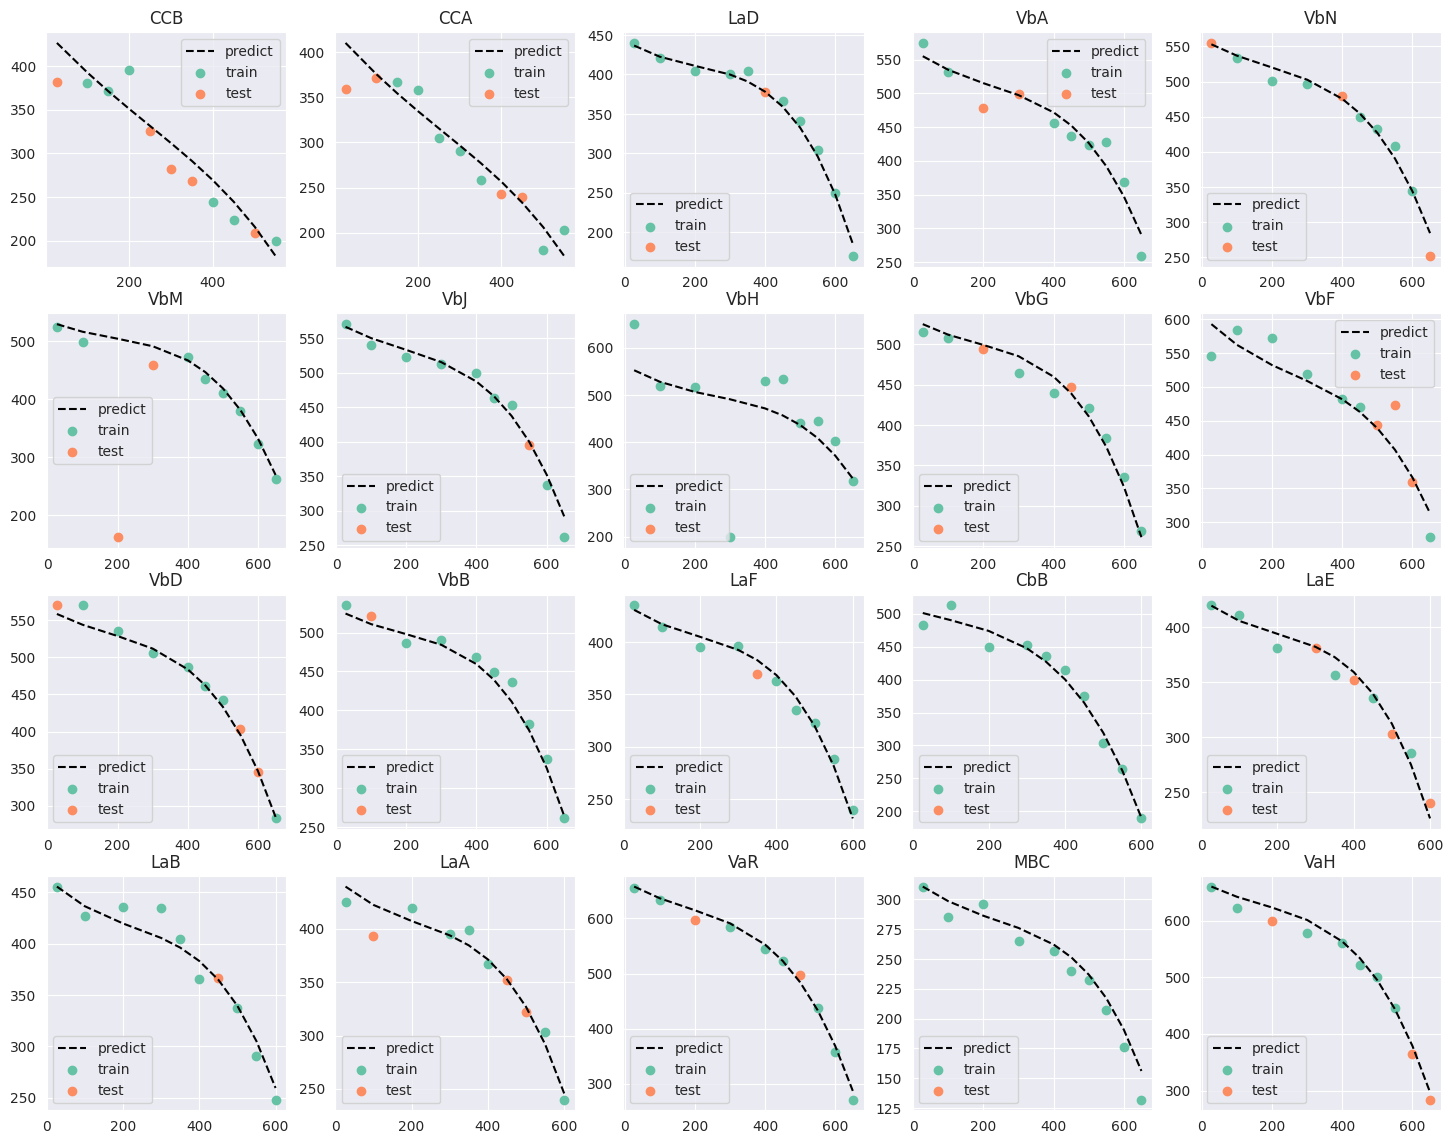

In [138]:
alloys = df['Alloy code'].value_counts().index[:20]

df_train = df.iloc[X_train.index]
df_test = df.iloc[X_test.index]

fig, axs = plt.subplots(nrows=4, ncols=5, figsize=(18, 14))

for alloy_label, i in zip(alloys, range(20)):
    alloy = df[df['Alloy code'] == alloy_label]
    alloy_test = df_test[df_test['Alloy code'] == alloy_label]
    alloy_train = df_train[df_train['Alloy code'] == alloy_label]
    ax = axs[i // 5][i % 5]
    # ax.scatter(alloy[' Temperature (°C)'], alloy[' 0.2% Proof Stress (MPa)'])
    ax.plot(alloy[' Temperature (°C)'], pipe.predict(X[df['Alloy code'] == alloy_label]), c='k', linestyle='--', label='predict')
    ax.scatter(alloy_train[' Temperature (°C)'], alloy_train[' 0.2% Proof Stress (MPa)'], label='train')
    ax.scatter(alloy_test[' Temperature (°C)'], alloy_test[' 0.2% Proof Stress (MPa)'], label='test')
    ax.set_title(alloy_label)
    ax.legend()

На это смотреть уже намного приятнее. Возможно, `r2_score` портится из-за выбросов по типу тех, что происходят на сплаве VbM или VbF.